In [114]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_digits, fetch_openml

from scipy.spatial.distance import pdist

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

import lib.baseline as baseline
import lib.util as util
from lib.baycon import baycon_explainer

from lib.eval.eval_metrics import *
from lib.dice_mod import Gainer, random_opt, gradient_ascent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
def plot_heatmap(X, y, C, random_point, fn, target_cluster, use_pca=False, solutions=None, histories=None):

    dim_ranges = np.abs(np.max(X, axis=0) - np.min(X, axis=0))
    samples = []
    for _ in range(1):
        sample = np.random.rand(1, X.shape[1]) * dim_ranges + np.min(X, axis=0)
        samples.append(sample)
    samples = np.array(samples).reshape(-1, X.shape[1])
    sample_gains = np.array([fn(point.reshape(1, -1)) for point in samples])
    best_samples = samples[np.argsort(-sample_gains)[:10]]
    bs = best_samples.copy()

    if use_pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        best_samples = pca.transform(best_samples)
        random_point = pca.transform(random_point)
        if solutions is not None:
            solutions = [pca.transform(solution) for solution in solutions]
        if histories is not None:
            histories = [pca.transform(history) for history in histories]
    
    plt.figure(figsize=(10, 8))

    # Create a grid for the heatmap
    if not use_pca:
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                            np.linspace(y_min, y_max, 250))
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        values = np.array([fn(point.reshape(1, -1)) for point in grid_points])
        grid = values.reshape(xx.shape)
        plt.contourf(xx, yy, grid, levels=50, cmap='viridis', alpha=0.5)
        plt.colorbar(label='value')


    # values = np.array([fn(point.reshape(1, -1)) for point in samples])

    # Plot data points, cluster centers, and random point
    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette

    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette)
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='red', s=100, marker='o')
    sns.scatterplot(x=random_point[:, 0], y=random_point[:, 1], color='green', s=100, marker='o')
    # sns.scatterplot(x=best_samples[:, 0], y=best_samples[:, 1], color='blue', s=50, marker='x')
    if solutions is not None:
        for s in solutions:
            sns.scatterplot(x=s[:, 0], y=s[:, 1], color='purple', s=100, marker='o')
    if histories is not None:
        for h in histories:
            plt.plot(h[:, 0], h[:, 1], color='black', linewidth=1, linestyle='dashed', markersize=10, marker='x')

    plt.title(f'Heatmap of values for target cluster {target_cluster} ({fn.__name__})')
    # plt.axis('equal')
    plt.show()
    return bs

1.0


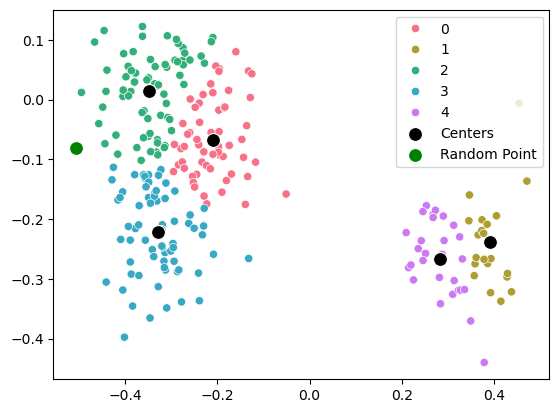

In [87]:
k = 5

X, _ = make_blobs(centers=k, cluster_std=2, n_features=2, n_samples=250)
# X, y = load_iris(return_X_y=True)
# X = StandardScaler().fit_transform(X)
X = X / np.max(pdist(X))
print(np.max(pdist(X)))
# normalize to max 1 dist
km = KMeans(n_clusters=k)
y = km.fit_predict(X)
C = km.cluster_centers_

# random point from X:
random_point = X[[np.random.randint(0, X.shape[0])]]


def plot(X, y, C, x, pca=False):
    if pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        x = pca.transform(x)
    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, legend="full")
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='black', s=100, marker='o', label='Centers')
    sns.scatterplot(x=x[:, 0], y=x[:, 1], color='green', s=100, marker='o', label='Random Point')
    plt.legend()
    plt.show()

plot(X, y, C, random_point, pca=False)

X: (250, 2)
C: (5, 2)
x: (1, 2)
iter: 35
iter: 31
iter: 35
iter: 35
iter: 37


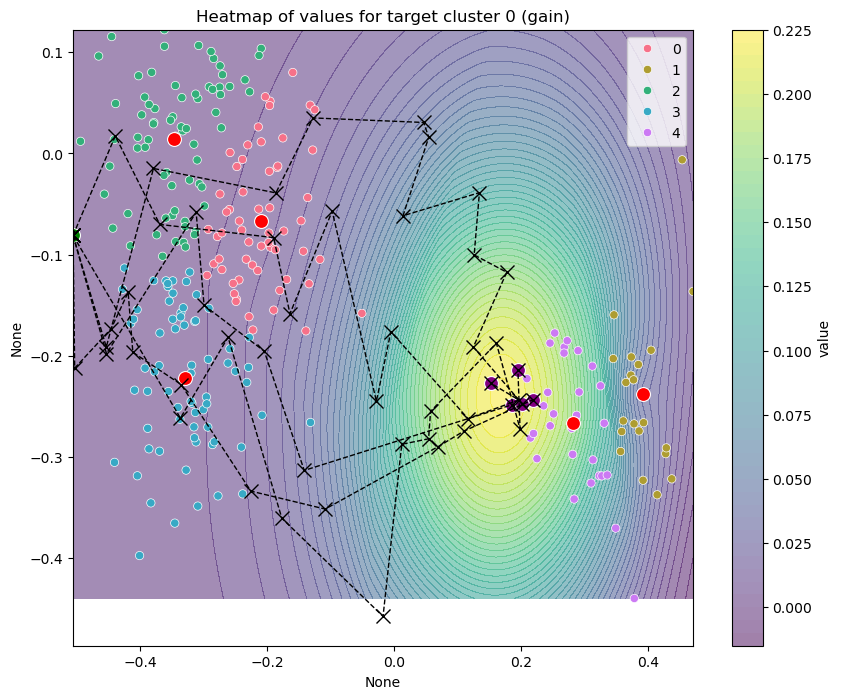

In [89]:
# Example usage
l = Gainer(C, X, 4, random_point)

sols = []
hists = []
for i in range(5):
    sol, hist = random_opt(random_point, l.gain)
    sols.append(sol)
    hists.append(hist)

best = plot_heatmap(
    X, y, C, random_point, l.gain, target_cluster=0, 
    use_pca=False, 
    solutions=sols, 
    histories=hists
)
# print(best[0].reshape(1, -1).shape)

# valid = np.array([l.is_valid(point.reshape(1,-1)) for point in best])
# sparsity = np.array([l.sparsity_gain(point) for point in best])
# df = pd.DataFrame()
# df['valid'] = valid
# df['sparsity'] = sparsity
# print(df)

# for lt in l.gain_weights.keys():
#     sols = []
#     hists = []
#     for i in range(5):
#         sol, hist = random_opt(random_point, lt)
#         sols.append(sol)
#         hists.append(hist)
#     plot_heatmap(X, y, C, random_point, lt, target_cluster=0, use_pca=False, solutions=sols, histories=hists)

(1797, 64)
real label: 5
cluster label: 1
cluster accuracy: 0.16082359488035614


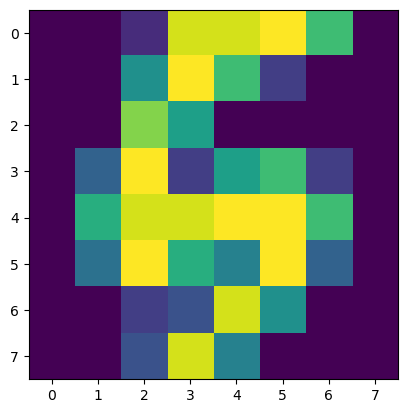

In [ ]:
k = 10
# mnist = load_digits()
# X = mnist.data
# target = mnist.target
X, target = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape)
X = X / np.max(pdist(X))
km = KMeans(n_clusters=k)
y = km.fit_predict(X)
C = km.cluster_centers_

idx = 678
random_point = X[idx].reshape(1, -1)
real_lbl = target[idx]
cluster_lbl = y[idx]

def showim(x):
    plt.imshow(x[0].reshape(8,8))
print(f"real label: {real_lbl}")
print(f"cluster label: {cluster_lbl}")
print(f"cluster accuracy: {np.mean(km.predict(X) == mnist.target)}")
showim(random_point)

In [110]:
l = Gainer(C, X, 3, random_point)
sol, _hist = gradient_ascent(random_point, l.gain)
print(sol)
print(sol == random_point)
showim(sol)
print(km.predict(sol))

X: (1797, 64)
C: (10, 64)
x: (1, 64)
iter: 1, imp: 0.004797120534969557, grad: 2.3600861757554488
iter: 2, imp: 0.004148917532781737, grad: 2.035659904251358
iter: 3, imp: 0.004168155471578561, grad: 2.040497322699023
iter: 4, imp: 0.004185452584025862, grad: 2.0448515373229146
iter: 5, imp: 0.004200766192673899, grad: 2.0487148961759956
iter: 6, imp: 0.004214059003025961, grad: 2.0520807465364648
iter: 7, imp: 0.004225299394897575, grad: 2.0549434858116165
iter: 8, imp: 0.004234461660647504, grad: 2.0572986000990015
iter: 9, imp: 0.004241526200260082, grad: 2.0591426955522465
iter: 10, imp: 0.00424647967317443, grad: 2.060473523125525
iter: 11, imp: 0.004249315105466667, grad: 2.061289996628482
iter: 12, imp: 0.004250031951022637, grad: 2.0615922039330514
iter: 13, imp: 0.00424863610586762, grad: 2.06138141120108
iter: 14, imp: 0.004245139875323378, grad: 2.060660060063331
iter: 15, imp: 0.004239561894311739, grad: 2.0594317577537793
iter: 16, imp: 0.004231927001720648, grad: 2.057701

KeyboardInterrupt: 